In [100]:
%config InlineBackend.figure_formats = ['retina']
%matplotlib inline
import awkward
import uproot
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uproot_methods

import sys
sys.path.insert(0,"matplottery/")
from matplottery import Hist1D, plot_stack
from matplottery.utils import clopper_pearson_error

In [101]:
f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau50mm.root")
# f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau5mm.root")
t = f["Events"]

In [102]:
tlead = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("LeadingPair_*",outputtype=dict,namedecode="ascii").items()})
tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("DV_*",outputtype=dict,namedecode="ascii").items()})
tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_*",outputtype=dict,namedecode="ascii").items()})
tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("GenMuon_*",outputtype=dict,namedecode="ascii").items()})

tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
tdv["rho"] = np.hypot(tdv.x,tdv.y)
tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)

In [103]:
def make_plot(num,den,**kwargs):
    import matplotlib.ticker
    def ratio_callback(ax):
        ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(0.1))
        ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(0.5))
    mean_eff = num.get_integral()/den.get_integral()
    if "title" in kwargs: kwargs["title"] += r", $\epsilon=${:.1f}%".format(mean_eff*100.0)
#     print(kwargs)
    return plot_stack(
        bgs=[num,den],
        do_stack=False,
        ratio = Hist1D(num.divide(den,binomial=True),label="num/den"),
        ratio_range=[0,1.],
        ylabel="Events",
        ax_ratio_callback=ratio_callback,
        **kwargs,
    );

In [104]:
# goodgenpt = ((tgen.pt[:,:2]>3.).sum()>=2).mean()
# (np.abs(tgen.eta[:,:2]<2.4).sum()>=2).mean()
goodgen = (
    (tgen.pt>4.)
    & (np.abs(tgen.eta)<2.4)
)

In [105]:
# ((tgen.pt>3.).sum()>=2).mean()
goodgen[:,:2].sum().mean()/2.

0.7666103896103896

[<Figure size 750x500 with 2 Axes>,

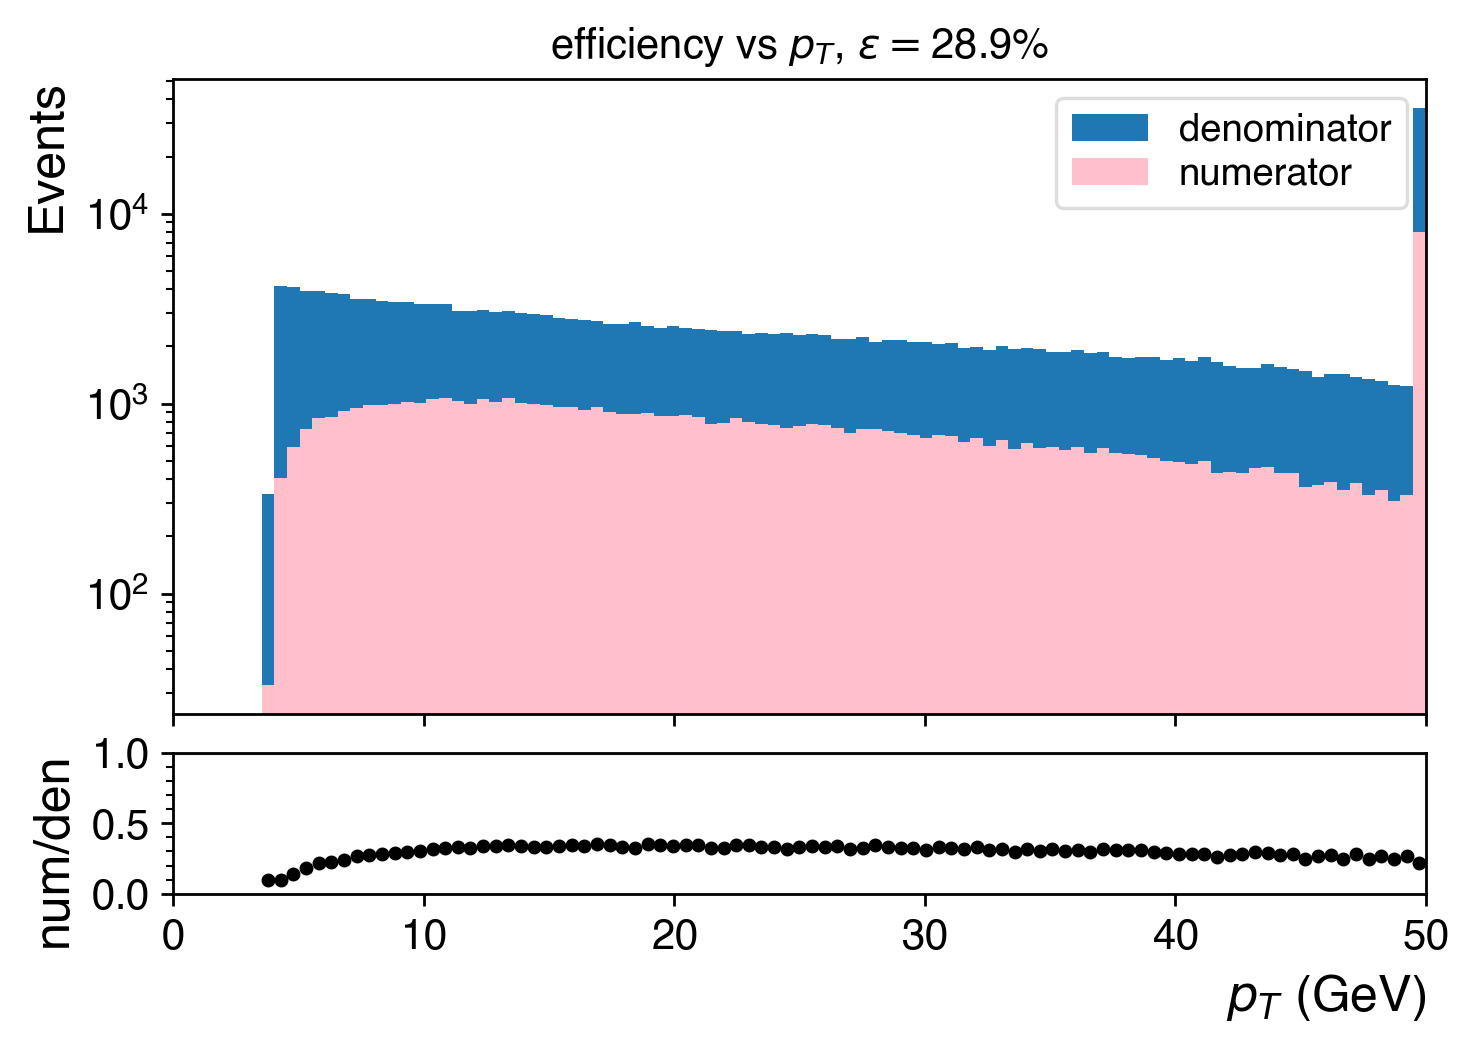

In [106]:
bins = np.linspace(0,50,100)
genvar = tgen.pt[goodgen]
label = "$p_T$ (GeV)"

passden = (genvar.counts >= 2)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)

den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")

make_plot(num,den,xlabel=label,title=r"efficiency vs $p_T$",do_log=True,filename="plots/eff_vs_pt.png")

[<Figure size 750x500 with 2 Axes>,

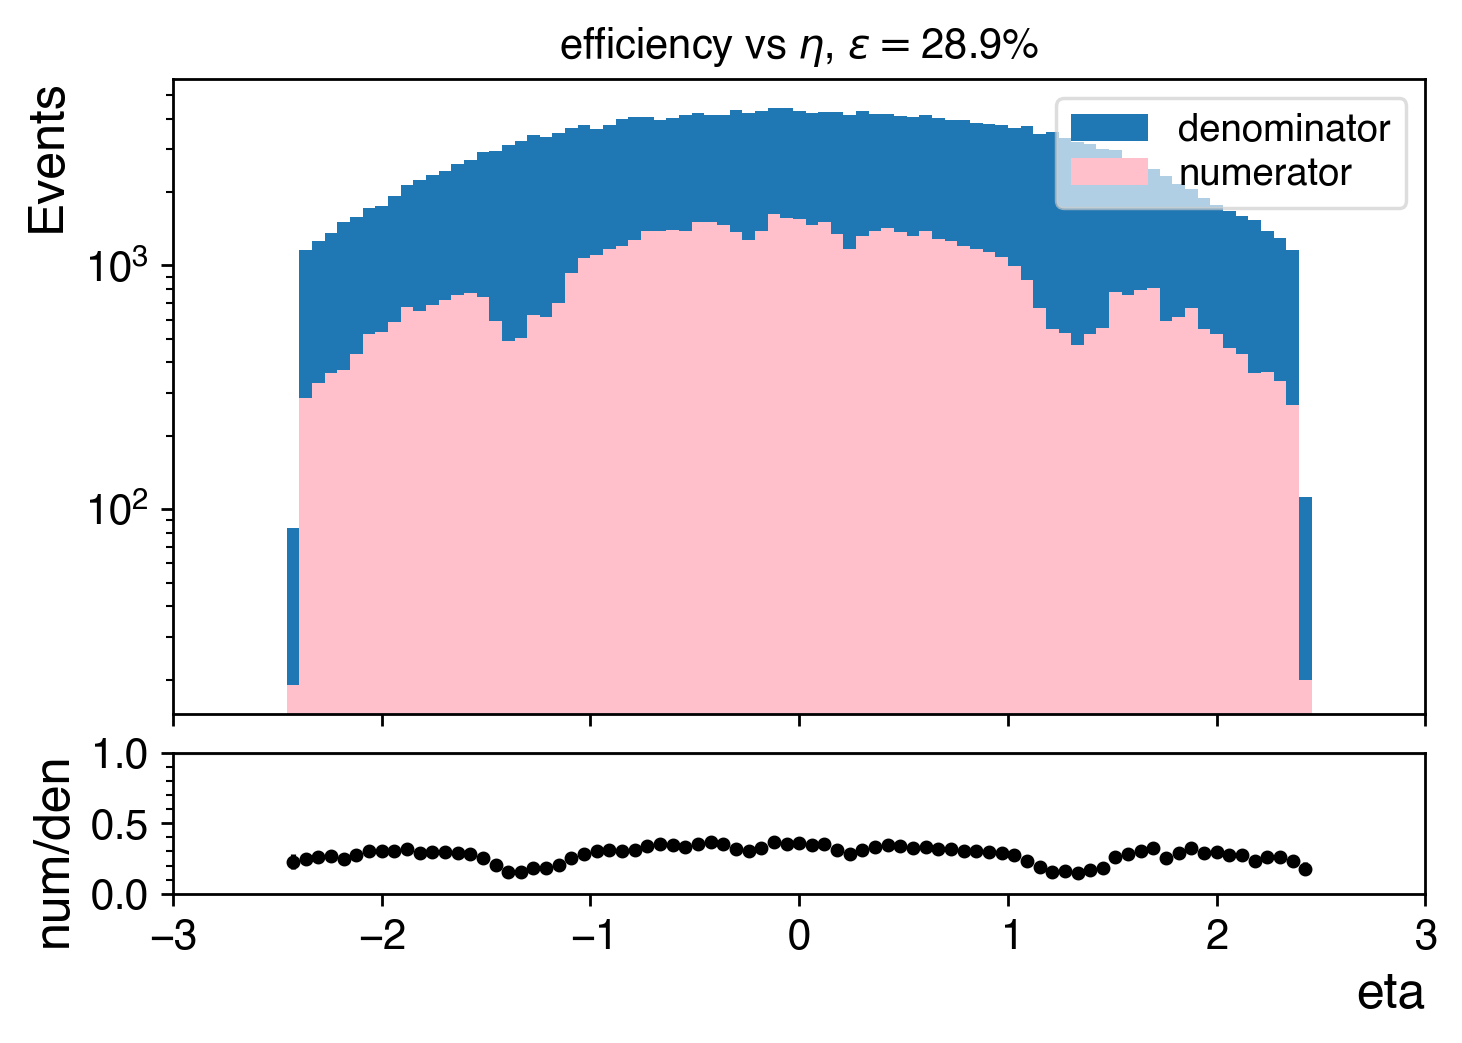

In [107]:
bins = np.linspace(-3,3,100)
genvar = tgen.eta[goodgen]
label = "eta"

passden = (genvar.counts >= 2)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)

den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")


make_plot(num,den,xlabel=label,title=r"efficiency vs $\eta$",do_log=True,filename="plots/eff_vs_eta.png")

[<Figure size 750x500 with 2 Axes>,

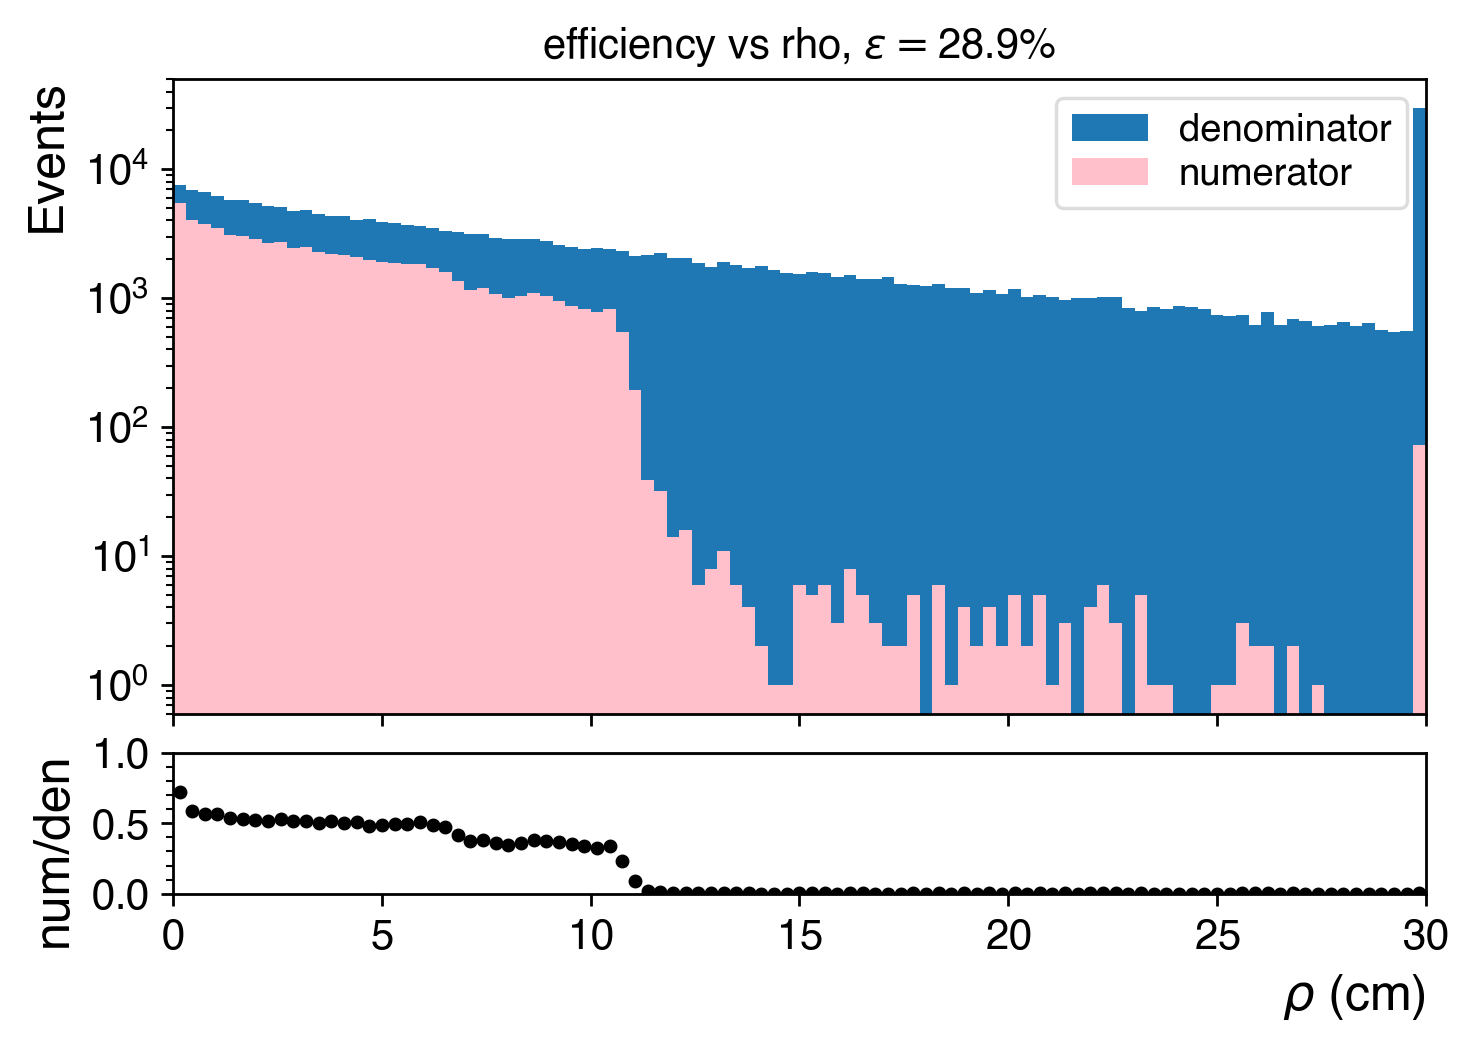

In [108]:
bins = np.linspace(0,30,100)
genvar = tgen.rho[goodgen]
label = r"$\rho$ (cm)"

passden = (genvar.counts >= 2)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)

den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")

make_plot(num,den,xlabel=label,title=r"efficiency vs rho",do_log=True,filename="plots/eff_vs_rho.png")

[<Figure size 750x500 with 2 Axes>,

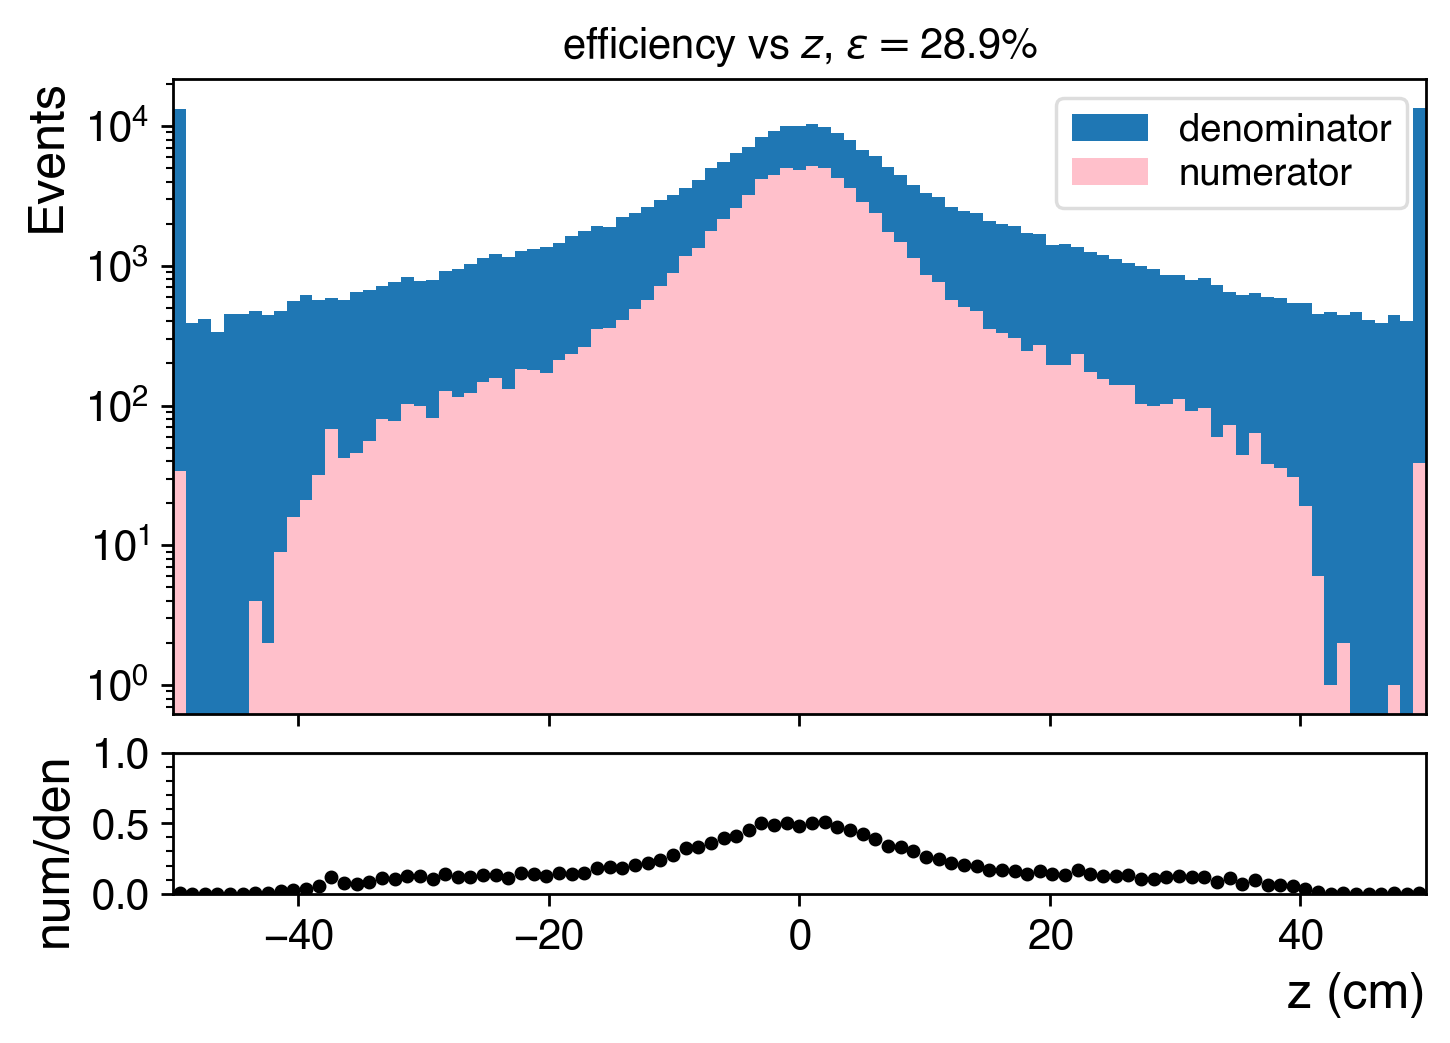

In [109]:
bins = np.linspace(-50,50,100)
genvar = tgen.vz[goodgen]
label = "z (cm)"

passden = (genvar.counts >= 2)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)

den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")

make_plot(num,den,xlabel=label,title=r"efficiency vs $z$",do_log=True,filename="plots/eff_vs_z.png")

In [110]:
goodptdr = (
    (((tgen.pt[:,0] > 15) | (tgen.pt[:,1] > 15)) & (tgen.pt[:,0] > 7) & (tgen.pt[:,1] > 7))
    | (tgen.p4[:,0].delta_r(tgen.p4[:,1])<1.2)
)
goodeta = ((np.abs(tgen.eta[:,0])<2.4) & (np.abs(tgen.eta[:,1])<2.4))

goodrho = ((tgen.rho[:,0])<9.5)
goodz = ((np.abs(tgen.vz[:,0]))<35.)

# goodrho = ((tgen.rho[:,0])<6.0)
# goodz = ((np.abs(tgen.vz[:,0]))<28.)

# goodrho = ((tgen.rho[:,0])<2.5)
# goodz = ((np.abs(tgen.vz[:,0]))<24.)

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/IPython/core/events.py:88: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/IPython/core/pylabtools.py:128: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


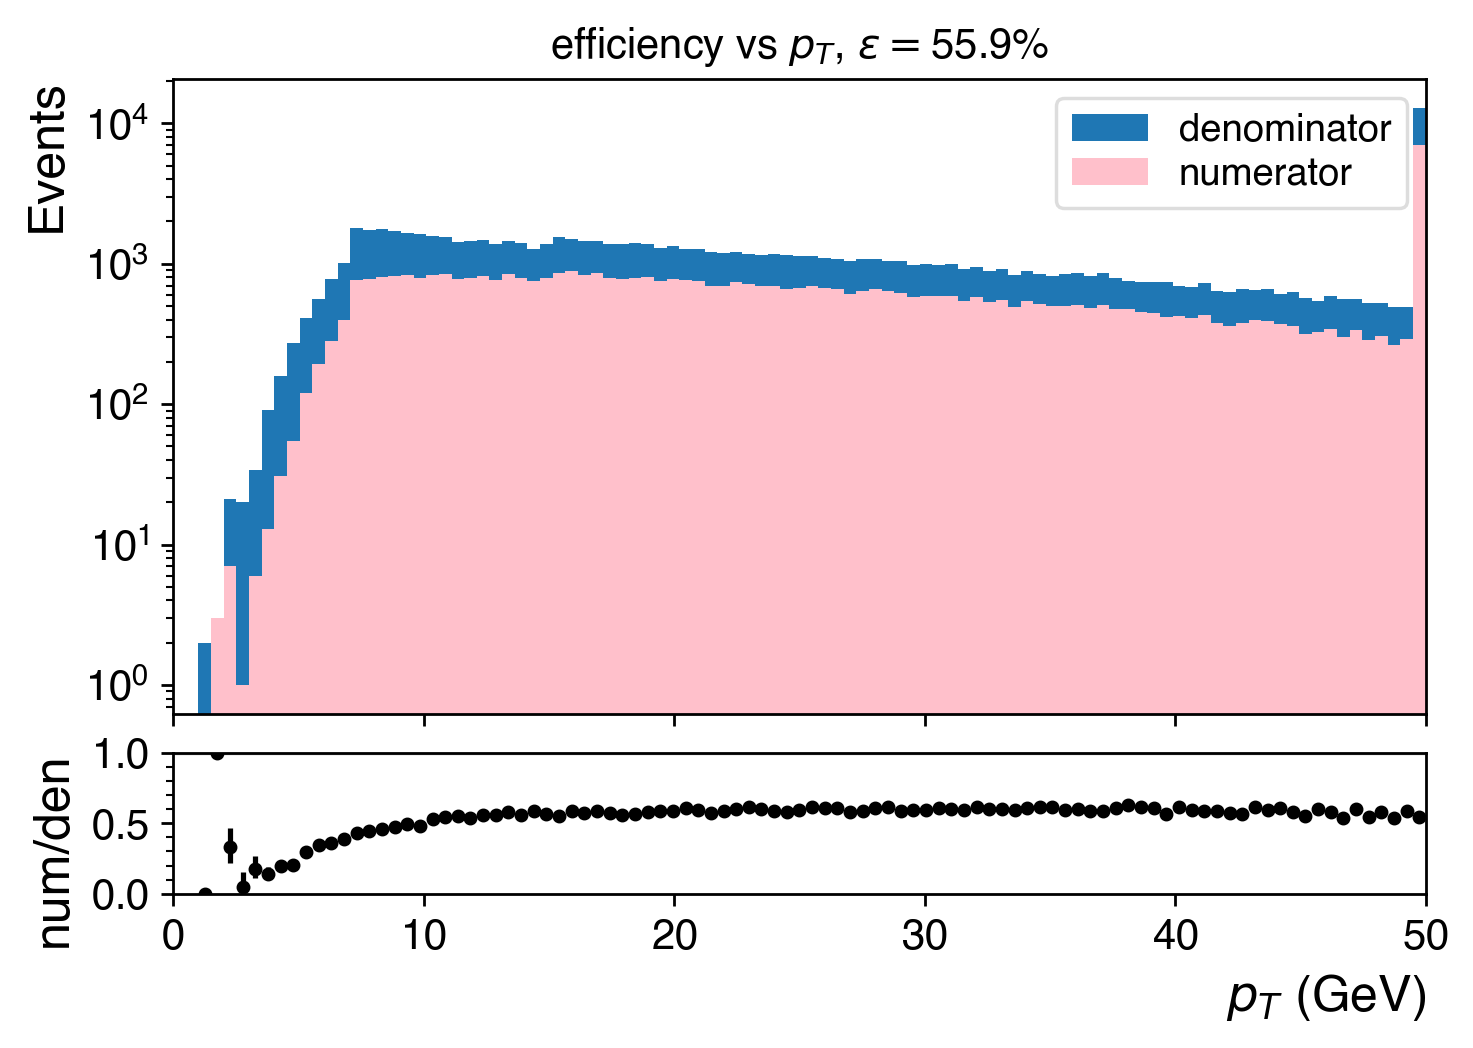

In [111]:
bins = np.linspace(0,50,100)
genvar = tgen.pt
label = r"$p_T$ (GeV)"
passden = (genvar.counts >= 2) & (goodptdr & goodeta & goodz & goodrho)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)
den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")
fig,(ax_main,ax_ratio)=make_plot(num,den,xlabel=label,title=r"efficiency vs $p_T$",do_log=True)
# ax_main.set_xscale("log")
fig.set_tight_layout(True)
fig.savefig("plots/recoeff_vs_pt_fid.png")

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


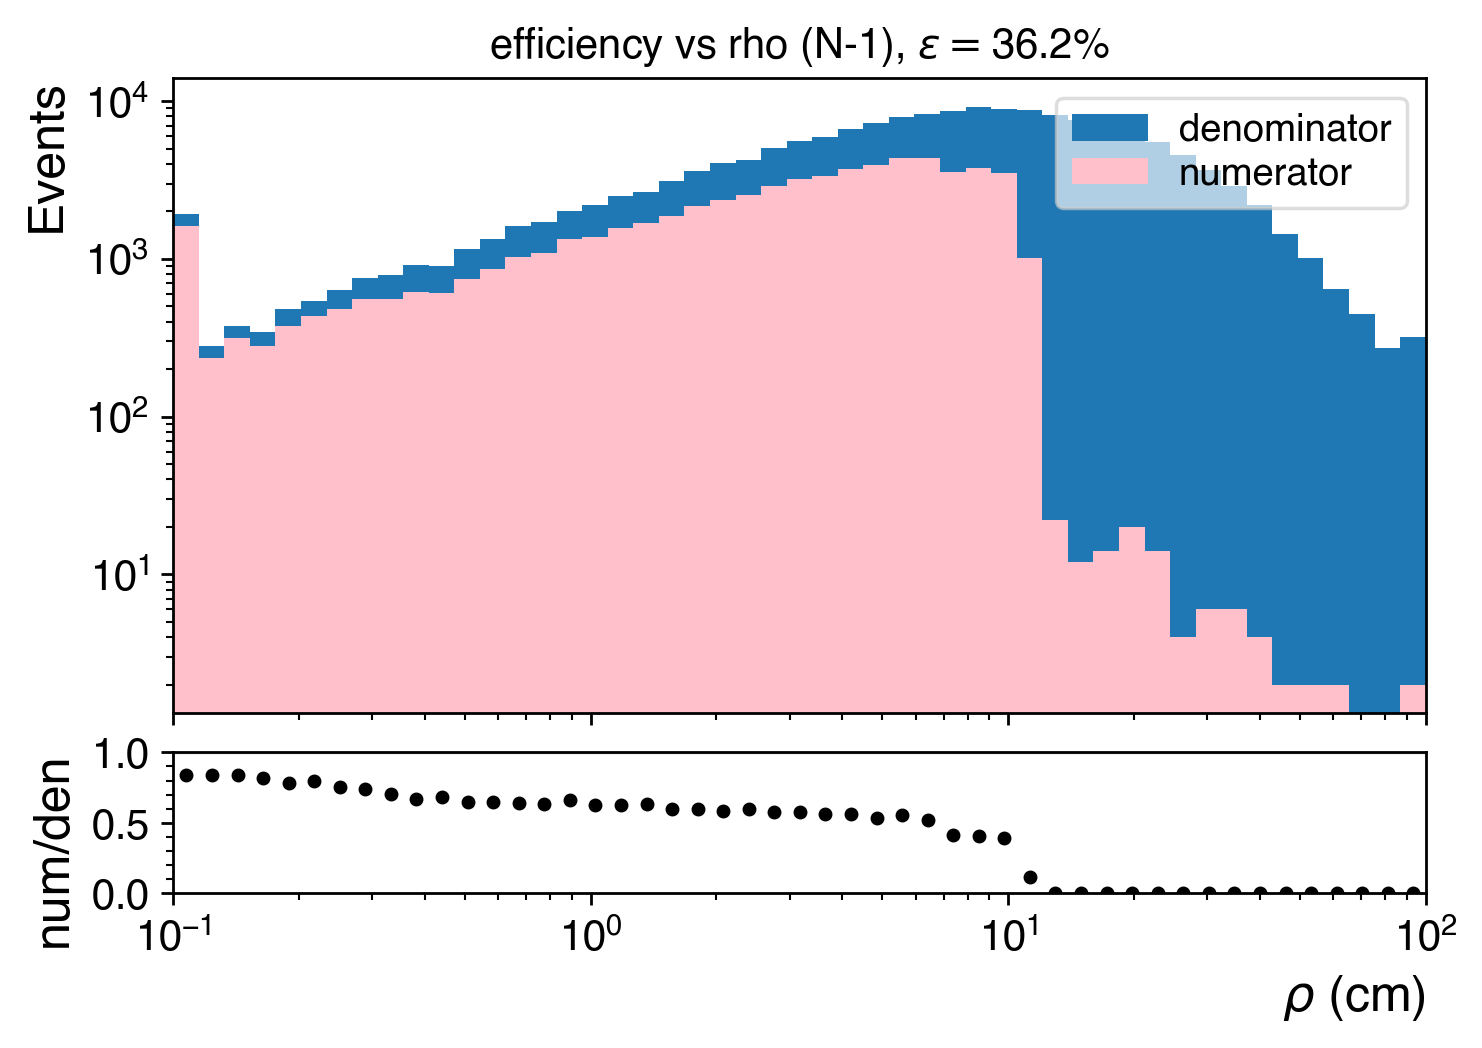

In [114]:
bins = np.logspace(-1,2,50)
genvar = tgen.rho
label = r"$\rho$ (cm)"
passden = (genvar.counts >= 2) & (goodptdr & goodeta & goodz)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)
den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")
fig,(ax_main,ax_ratio)=make_plot(num,den,xlabel=label,title=r"efficiency vs rho (N-1)",do_log=True)
ax_main.set_xscale("log")
fig.set_tight_layout(True)
fig.savefig("plots/recoeff_vs_rho_nm1fid.png")

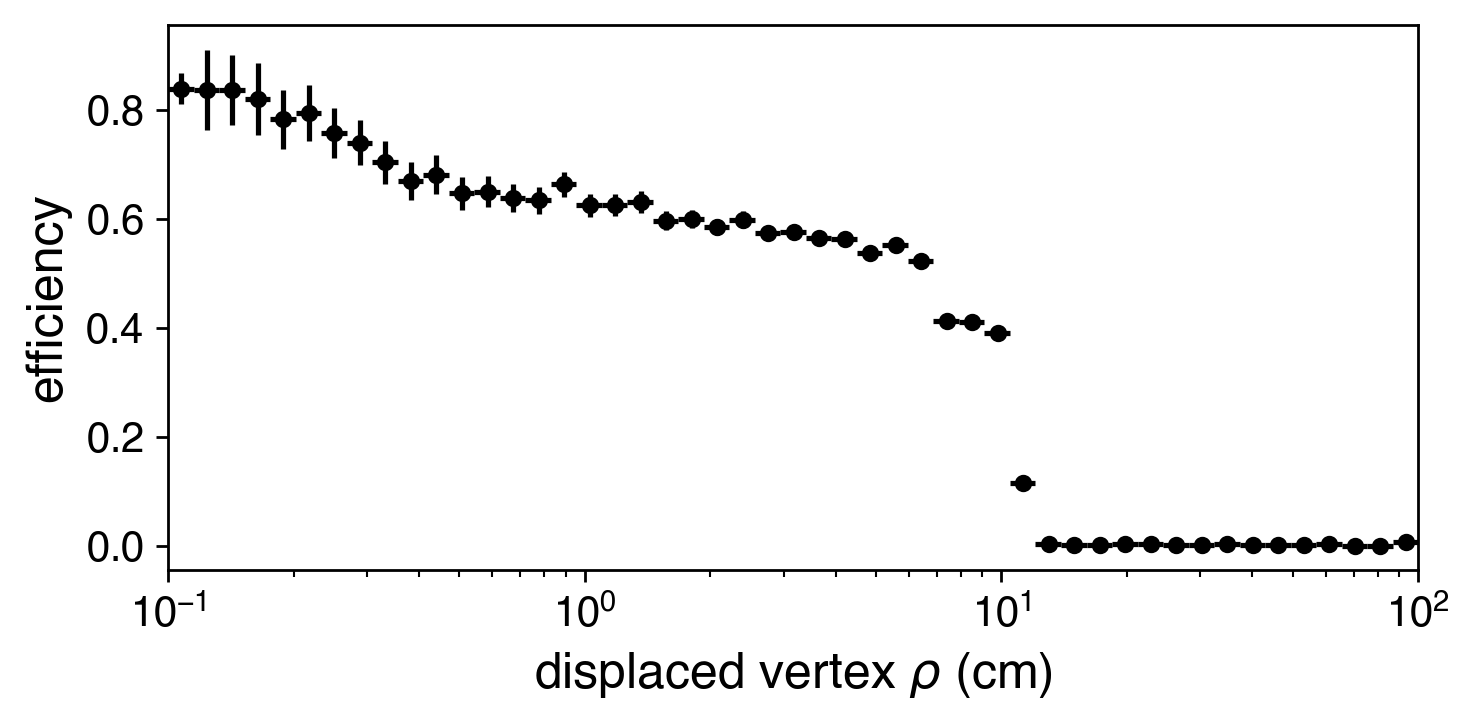

In [136]:
# for claudio (just ratio of previous plot)

# label = r"$\rho$ (cm)"
num/den
fig,ax = plt.subplots(figsize=(6,3))
ratio = num/den
ax.errorbar(x=ratio.get_bin_centers(),y=ratio.counts,yerr=ratio.errors,color="k",fmt="o",markersize=4.0,xerr=ratio.get_bin_widths()/2)
ax.set_xlabel(r"displaced vertex $\rho$ (cm)")
ax.set_ylabel(r"efficiency")
# fig,(ax_main,ax_ratio)=make_plot(num,den,xlabel=label,title=r"efficiency vs rho (N-1)",do_log=True)
ax.set_xscale("log")
fig.set_tight_layout(True)

os.system("mkdir -p plots_for_claudio")
fig.savefig("plots_for_claudio/effrho_fiducial.png")
fig.savefig("plots_for_claudio/effrho_fiducial.pdf")

/home/users/namin/miniconda3/envs/analysisenv/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  # This is added back by InteractiveShellApp.init_path()


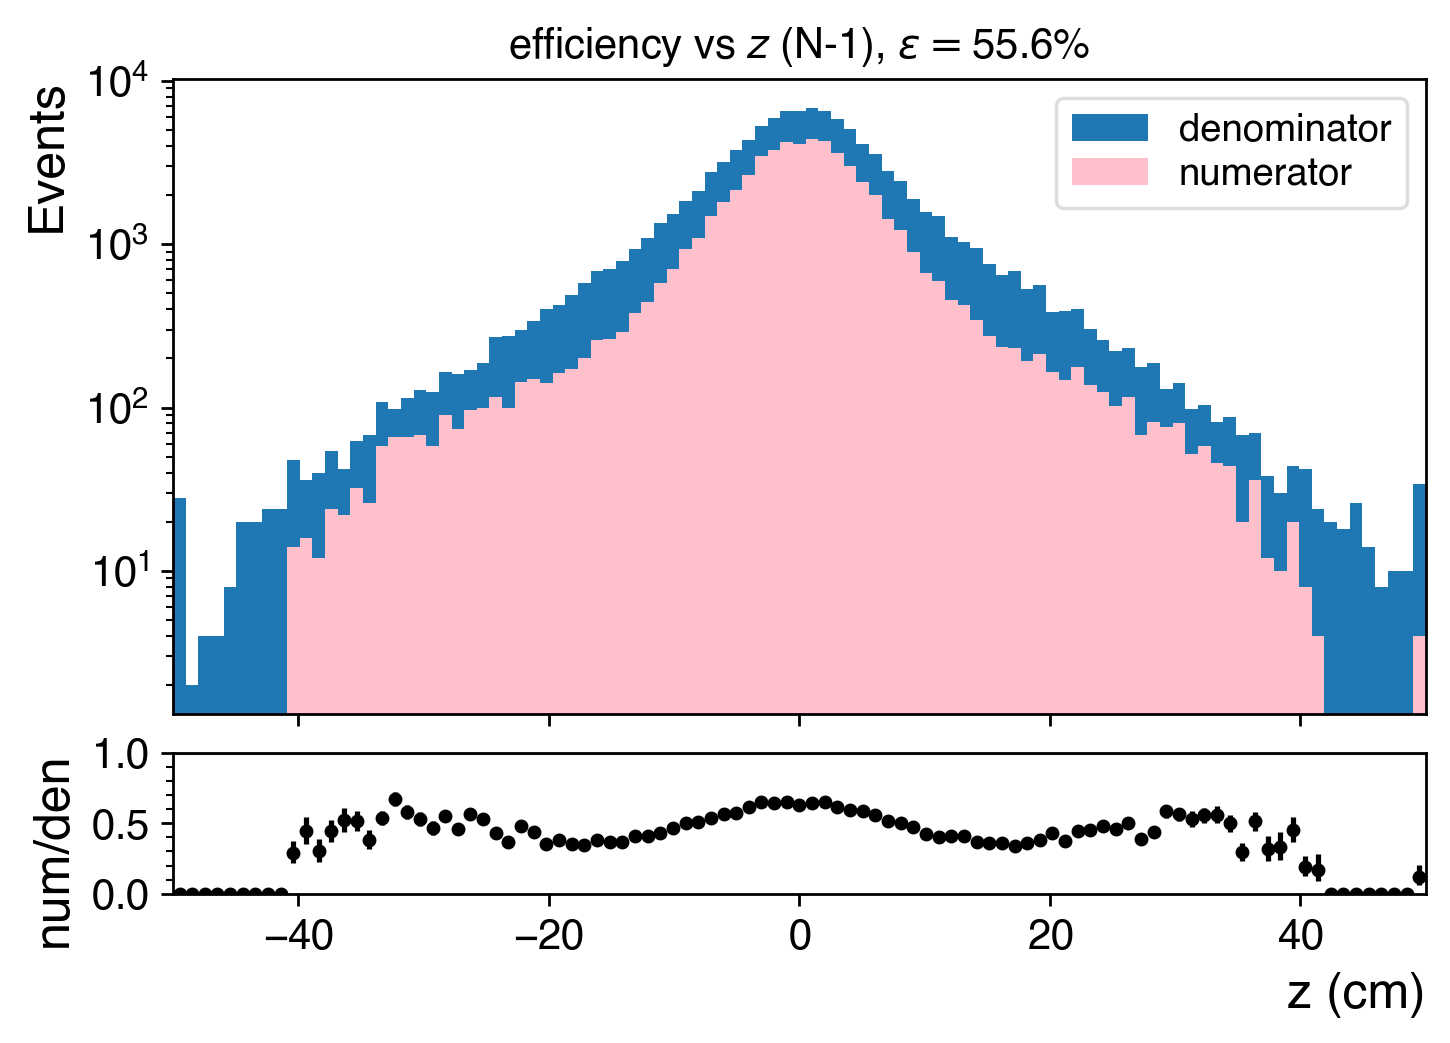

In [113]:
bins = np.linspace(-50,50,100)
genvar = tgen.vz
label = "z (cm)"
passden = (genvar.counts >= 2) & (goodptdr & goodeta & goodrho)
passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)
den = Hist1D(genvar[passden][:,:2].flatten(),bins=bins,label="denominator",color="C0")
num = Hist1D(genvar[passden & passnum][:,:2].flatten(),bins=bins,label="numerator",color="pink")
fig,(ax_main,ax_ratio)=make_plot(num,den,xlabel=label,title=r"efficiency vs $z$ (N-1)",do_log=True)
# ax_main.set_xscale("log")
fig.set_tight_layout(True)
fig.savefig("plots/recoeff_vs_z_nm1fid.png")

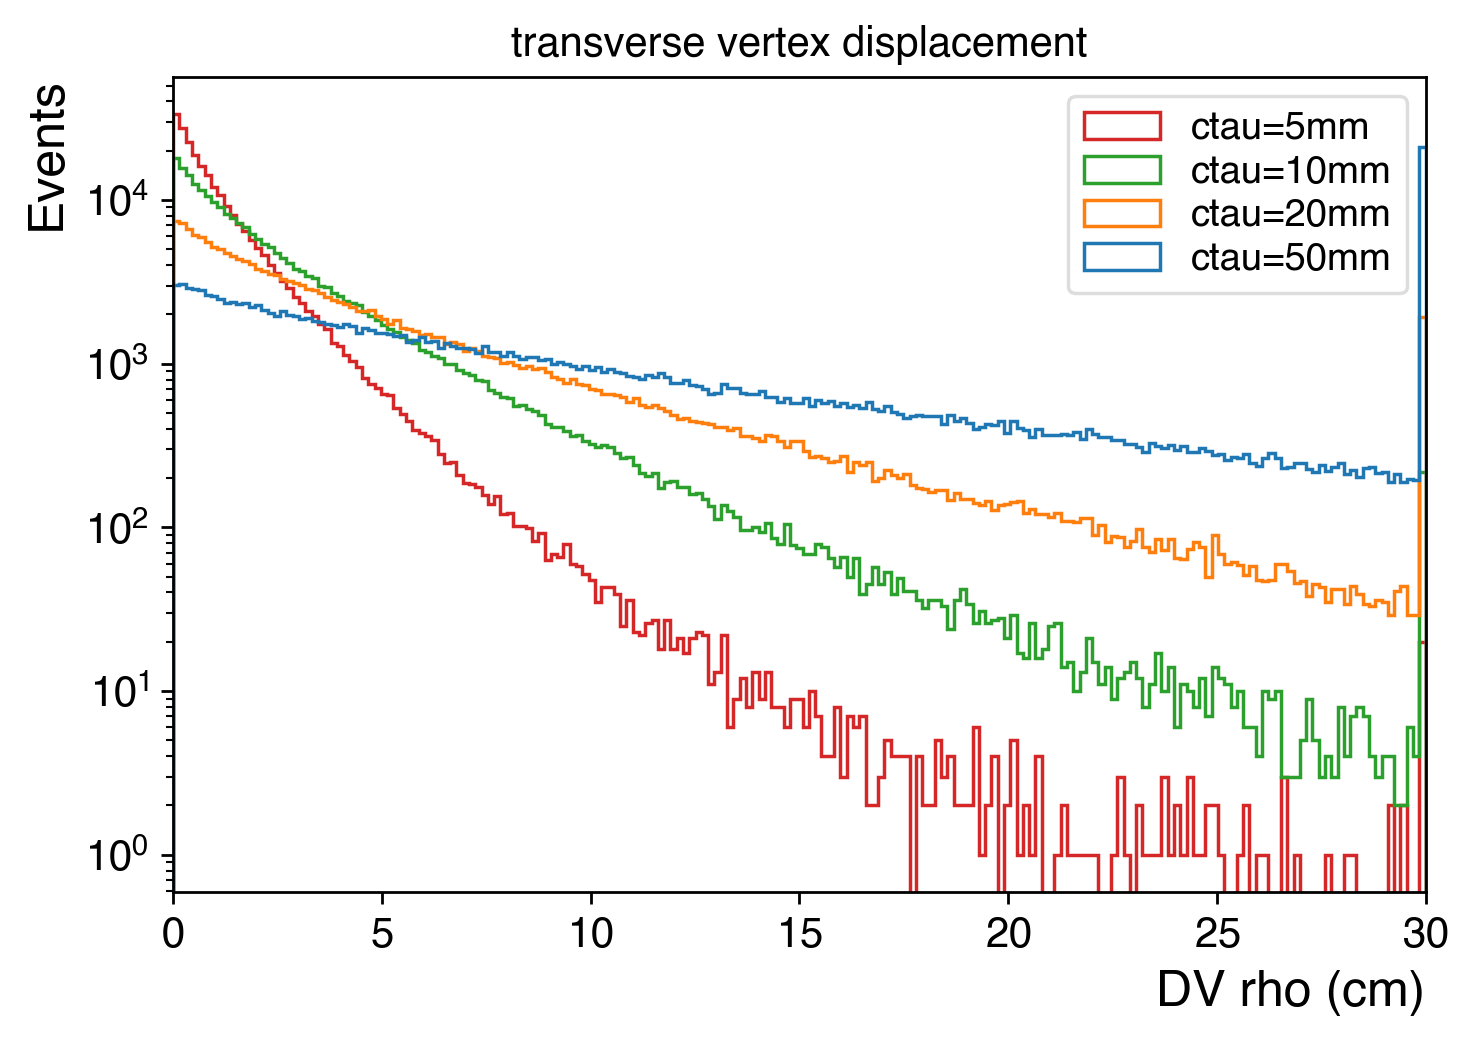

In [85]:
hists = []
for ctau in [50,20,10,5]:
    f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau{}mm.root".format(ctau))
    t = f["Events"]
    tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("/GenMuon_(pt|eta|phi|m|vx|vy)$/",outputtype=dict,namedecode="ascii").items()})
    tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
    hists.append(
        Hist1D(tgen.rho[:,0].flatten(),bins=np.linspace(0,30,200),label="ctau={}mm".format(ctau))
    )
plot_stack(
    bgs=hists,
    do_stack=False,
    ylabel="Events",
    xlabel="DV rho (cm)",
    mpl_hist_params = dict(
        histtype="step",
    ),
    do_log=True,
    title="transverse vertex displacement",
);

50 0.2885914666966588
20 0.4580120677247673
10 0.5604955802023769
5 0.6226581204159963


Text(0.5, 1.0, 'trigger*reco efficiency')

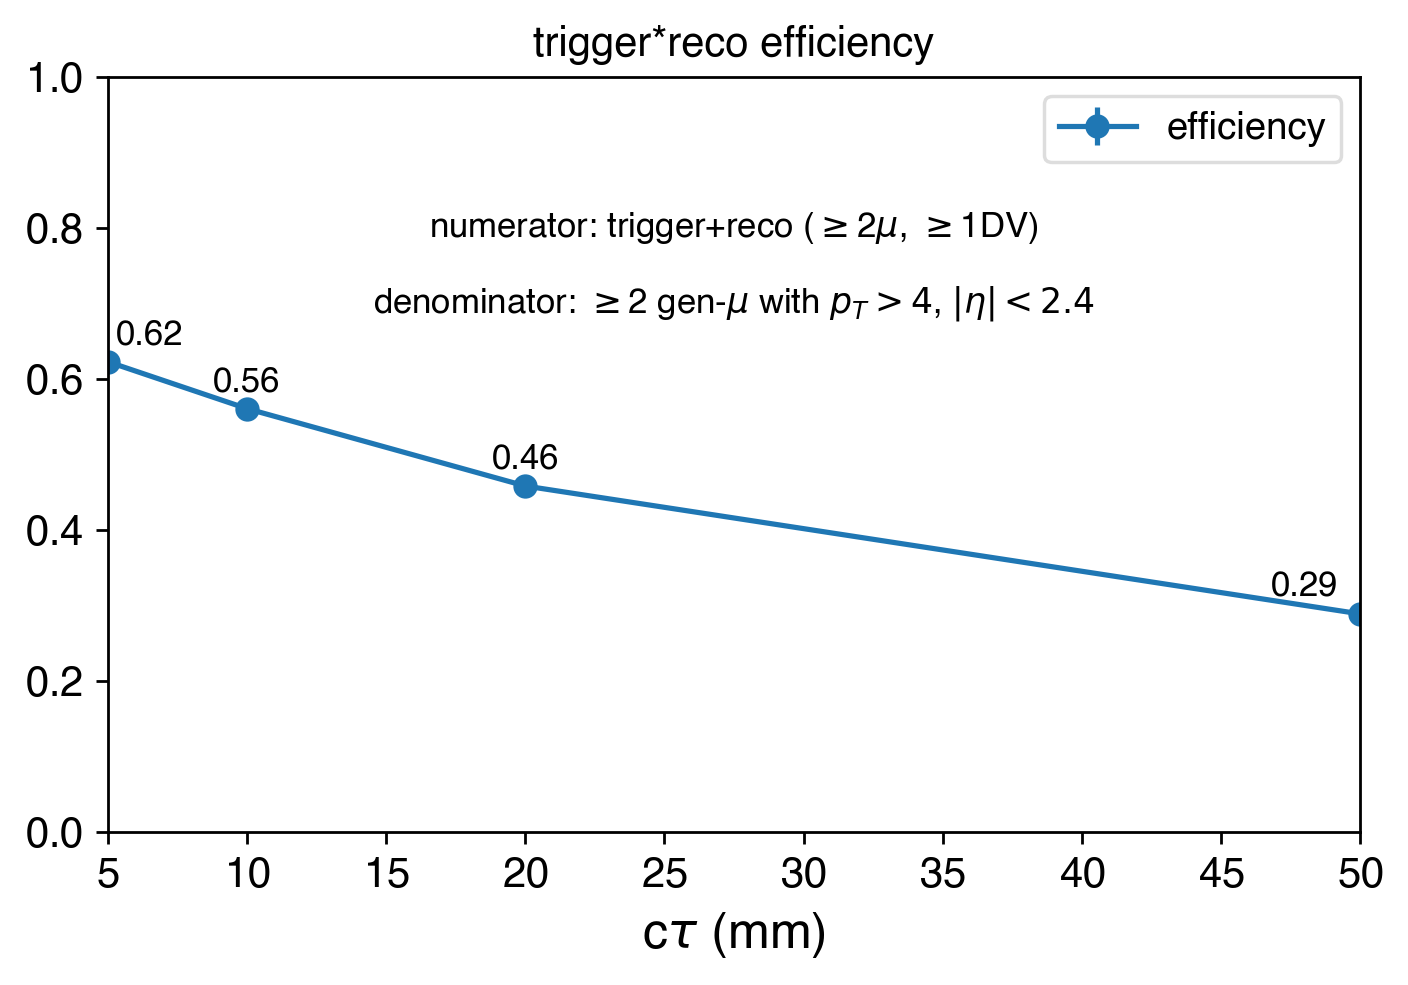

In [86]:

data = []
for ctau in [50,20,10,5]:
    f = uproot.open("/hadoop/cms/store/user/namin/DisplacedMuons/babies/baby_HToZZTo2Mu2X_ctau{}mm.root".format(ctau))
    t = f["Events"]
    tdv = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("/DV_(x|y)$/",outputtype=dict,namedecode="ascii").items()})
    tmu = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("Muon_pt",outputtype=dict,namedecode="ascii").items()})
    tgen = awkward.Table({k.split("_",1)[1]:v for k,v in t.arrays("/GenMuon_(pt|eta|phi|m|vx|vy)$/",outputtype=dict,namedecode="ascii").items()})

    tgen["rho"] = np.hypot(tgen.vx,tgen.vy)
    tdv["rho"] = np.hypot(tdv.x,tdv.y)
    tgen["p4"] = uproot_methods.TLorentzVectorArray.from_ptetaphim(tgen.pt,tgen.eta,tgen.phi,tgen.m)

    goodgen = (
        (tgen.pt>4.)
        & (np.abs(tgen.eta)<2.4)
    )

    genvar = tgen.pt[goodgen]
    passden = (genvar.counts >= 2)
    passnum = (tmu.pt.counts >= 2) & (tdv.x.counts >= 1)

    num = (passden & passnum).sum()
    den = passden.sum()
    eff = num/den
    print(ctau,eff)
    data.append(dict(ctau=ctau,eff=eff,num=num,den=den))

df = pd.DataFrame(data)
df

yerrup = (clopper_pearson_error(df.num.values,df.den.values)[1]-df.num/df.den)
df.set_index("ctau").eff.plot(marker="o",label="efficiency",yerr=yerrup)
ax = plt.gca()
ax.legend()
# ax.set_title(r"num. = trigger+reco ($\geq$2$\mu$, $\geq$1DV); den. = $\geq$2 gen-$\mu$ with $p_T>4$, $|\eta|<2.4$")
ax.set_xlabel(r"c$\tau$ (mm)")
ax.set_ylim([0.,1.])
ax.text(0.5,0.8,
        r"numerator: trigger+reco ($\geq$2$\mu$, $\geq$1DV)",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
       )
ax.text(0.5,0.7,
        r"denominator: $\geq$2 gen-$\mu$ with $p_T>4$, $|\eta|<2.4$",
        horizontalalignment="center",
        verticalalignment="center",
        transform=ax.transAxes,
       )
for x,y in zip(df["ctau"].values,df["eff"].values):
    ax.annotate("{:.2f}".format(y),
                xy=(max(min(x,48),6.5),y),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')
ax.set_title("trigger*reco efficiency")

<JaggedArray [[2.721792 2.268869] [2.0410664 4.9246545] [3.2191882 3.2937999] ... [] [] []] at 0x7f28b6022dd8>

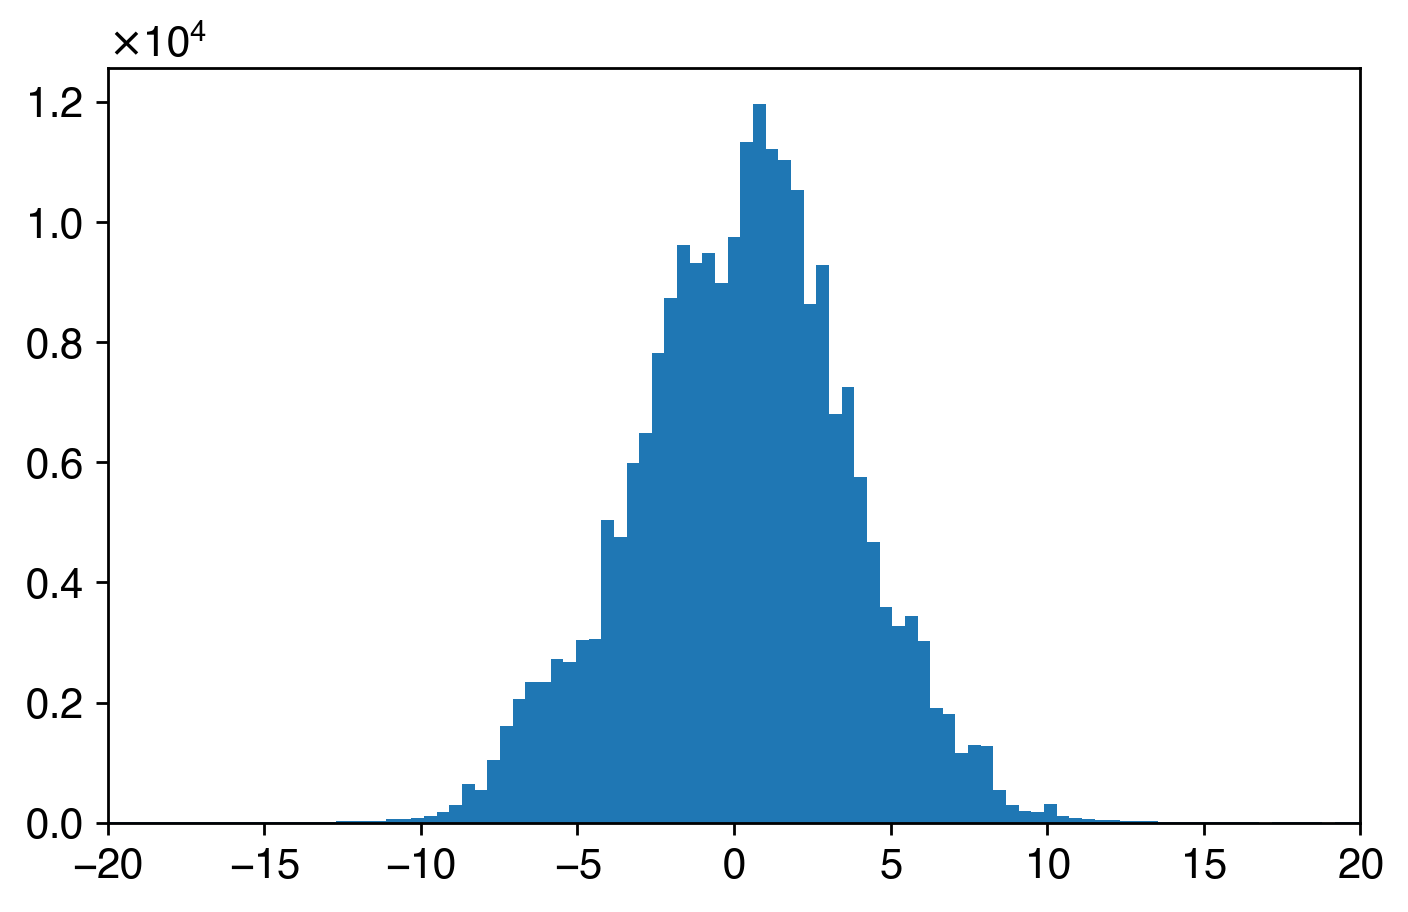

In [92]:
plt.hist(tmu.dz.flatten(),bins=np.linspace(-20,20,100));

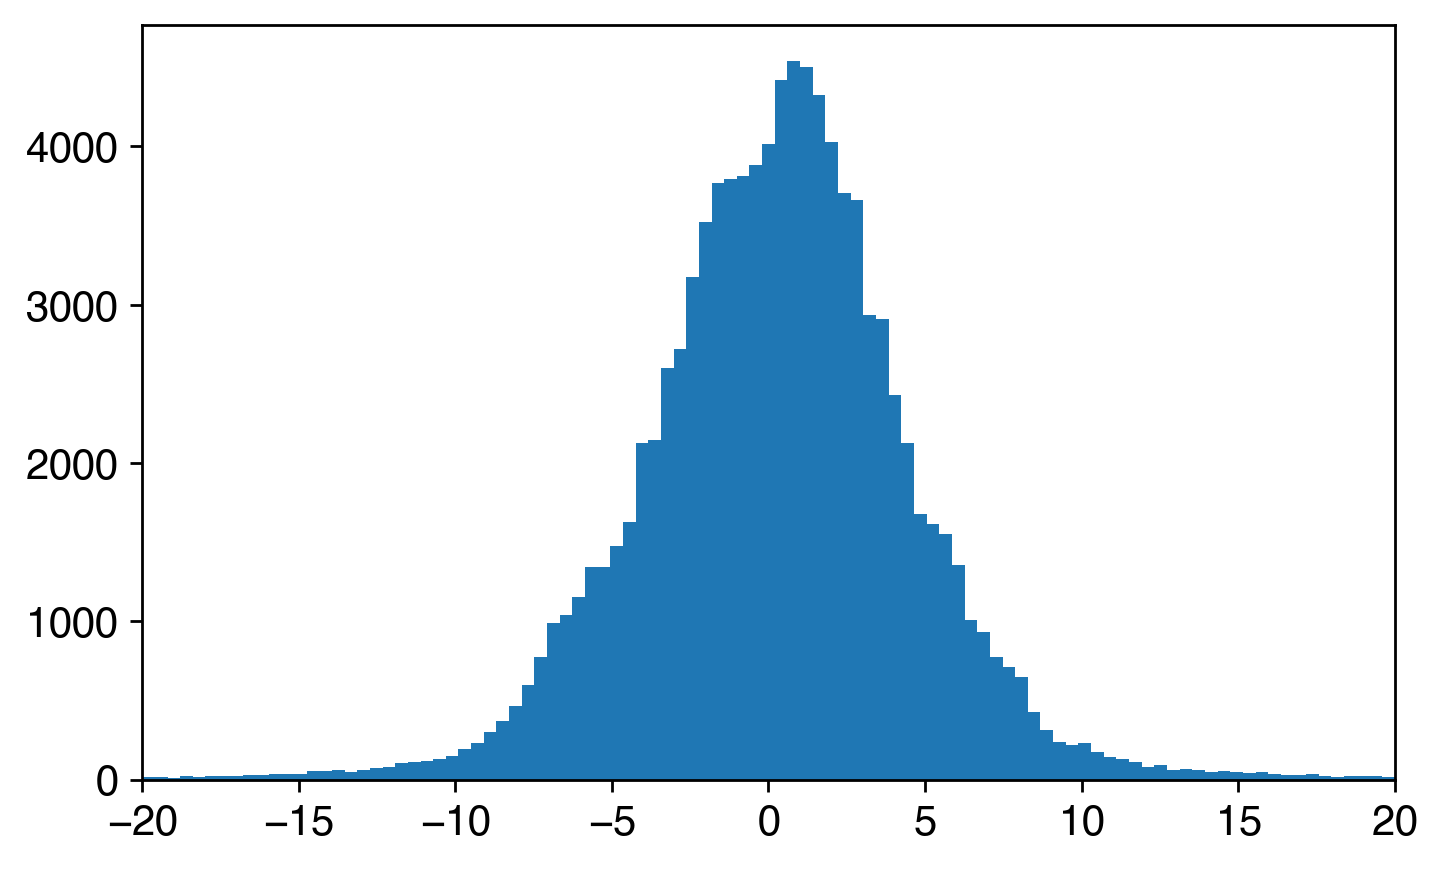

In [96]:
plt.hist(tdv.z.flatten(),bins=np.linspace(-20,20,100));